In [1]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib.table import Table
import seaborn as sns
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import datetime
from datetime import timedelta
from statistics import mode
from scipy.signal import find_peaks
from scipy import signal

import ast

# Libraries for Correlations
from scipy.stats import pearsonr, sem, variation, kruskal,f_oneway 
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
from scipy.spatial.distance import pdist, squareform
from scipy.cluster import hierarchy

%matplotlib inline


############################################

Processing the Glucose Values to Isolate the PPGR

############################################

In [2]:
def read_data(filename):
    unfiltered = pd.read_csv(os.path.join("CSV Files", filename))
    unfiltered['glucose_level_ts'] = pd.to_datetime(unfiltered['glucose_level_ts'], dayfirst=True)
    unfiltered['meal_ts'] = pd.to_datetime(unfiltered['meal_ts'], dayfirst=True)
    unfiltered['bolus_start_ts'] = pd.to_datetime(unfiltered['bolus_start_ts'], dayfirst=True)

    # Convert glucose levels from mg/dL to mmol/L
    unfiltered['glucose_level_mg/dL'] = (unfiltered['glucose_level_mg/dL'] * 0.0555).round(2)
    
    return unfiltered


In [3]:
def interleave_arrays_increasing(meal, bolus):
    result = []
    i, j = 0, 0
    while i < len(meal) and j < len(bolus):
        if meal[i] < bolus[j]:
            result.append(("meal", meal[i]))
            i += 1
        else:
            result.append(("bolus", bolus[j]))
            j += 1
    result.extend([("meal", meal[x]) for x in range(i, len(meal))])
    result.extend([("bolus", bolus[x]) for x in range(j, len(bolus))])
    return result


In [4]:
def glucoseForMealsTs(glucose_ts_array, meal_ts):
    closest_values = []
    for element in meal_ts:
        closest_index = np.abs(glucose_ts_array - element).argmin()
        closest_values.append(glucose_ts_array[closest_index])
    return np.array(closest_values)


In [5]:
def glucoseForEventsTs(glucose_ts_array, events_ts):
    closest_values = []
    for event_type, event_ts in events_ts:
        closest_index = np.abs(glucose_ts_array - event_ts).argmin()
        closest_value = glucose_ts_array[closest_index]
        
        if abs(closest_value - event_ts) <= pd.Timedelta(hours=4):
            closest_values.append((event_type, event_ts, closest_value))
    
    return closest_values


In [6]:
def bolusMealSeparation(meal_ts, bolus_start_ts, bolus_dose_filtered):
    viableBolusTimes = []
    for i in range(min(len(bolus_start_ts), len(bolus_dose_filtered))):
        isWithinRange = False
        for j in range(len(meal_ts)):
            if meal_ts[j] - pd.Timedelta(minutes=4) <= bolus_start_ts[i] <= meal_ts[j] + pd.Timedelta(hours=4):
                isWithinRange = True
                break
        if not isWithinRange:
            viableBolusTimes.append((bolus_start_ts[i], bolus_dose_filtered[i]))
    return viableBolusTimes


In [7]:
def groupBolus2(bolus_array):
    time_ranges = [
        ("6am-10am", datetime.time(6, 0), datetime.time(10, 0)),
        ("10am-2pm", datetime.time(10, 0), datetime.time(14, 0)),
        ("2pm-6pm", datetime.time(14, 0), datetime.time(18, 0)),
        ("6pm-10pm", datetime.time(18, 0), datetime.time(22, 0)),
    ]

    result = []
    df = pd.DataFrame(bolus_array, columns=['Timestamp', 'Value'])
    grouped = df.groupby(df['Timestamp'].dt.date)

    for date, group_data in grouped:
        daily_result = {'Date': date, 'TimeRanges': []}
        for label, start_time, end_time in time_ranges:
            time_mask = (group_data['Timestamp'].dt.time >= start_time) & (group_data['Timestamp'].dt.time < end_time)
            max_value = group_data.loc[time_mask, 'Value'].max()
            max_timestamps = group_data.loc[(time_mask) & (group_data['Value'] == max_value), 'Timestamp'].tolist()
            daily_result['TimeRanges'].append({
                'TimeRange': label,
                'MaxValue': max_value,
                'Timestamps': max_timestamps
            })
        result.append(daily_result)
    return result



In [8]:
def findTimestampsNotCoveredByMeals(result, meal_events):
    time_ranges = {
        "6am-10am": (datetime.time(6, 0), datetime.time(10, 0)),
        "10am-2pm": (datetime.time(10, 0), datetime.time(14, 0)),
        "2pm-6pm": (datetime.time(14, 0), datetime.time(18, 0)),
        "6pm-10pm": (datetime.time(18, 0), datetime.time(22, 0))
    }

    meal_events_set = set(meal_events)
    timestamps_not_covered = []

    for day_result in result:
        for time_range_result in day_result['TimeRanges']:
            time_range_label = time_range_result['TimeRange']
            timestamps = time_range_result['Timestamps']
            time_range_start, time_range_end = time_ranges[time_range_label]

            meal_events_within_range = False
            for meal in meal_events_set:
                meal_time = meal.time()
                time_range_start_datetime = datetime.datetime.combine(day_result['Date'], time_range_start)
                time_range_end_datetime = datetime.datetime.combine(day_result['Date'], time_range_end)

                if time_range_start_datetime <= meal <= time_range_end_datetime:
                    meal_events_within_range = True
                    break

            if not meal_events_within_range:
                timestamps_not_covered.extend(timestamps)
    return timestamps_not_covered


In [9]:
def filter_glucose_levels(glucose_ts_array, glucose_level_array, event_ts):
    start_time = event_ts
    end_time = event_ts + pd.Timedelta(hours=4)
    filtered_glucose_levels = []
    previous_timestamp = None
    for ts, level in zip(glucose_ts_array, glucose_level_array):
        if start_time <= ts <= end_time:
            if previous_timestamp is not None and (ts - previous_timestamp) > pd.Timedelta(minutes=30):
                break
            filtered_glucose_levels.append(level)
            previous_timestamp = ts
    return filtered_glucose_levels


###################################

Read and format DataFrame

###################################

In [10]:
# Read data from the original file
participant_file = '584_data.csv'  # Update this with the actual file name
unfiltered = read_data(participant_file)
unfiltered.sort_values('glucose_level_ts', inplace=True)
unfiltered.reset_index(drop=True, inplace=True)
glucose_level_ts = pd.to_datetime(unfiltered['glucose_level_ts'].copy().to_numpy(), dayfirst=True, errors='coerce')
glucose_level = unfiltered['glucose_level_mg/dL'].copy().to_numpy()  # Already converted to mmol/L
bolus_start_ts = pd.to_datetime(unfiltered['bolus_start_ts'].copy().to_numpy(), dayfirst=True, errors='coerce')
meal_ts = pd.to_datetime(unfiltered['meal_ts'].copy().to_numpy(), dayfirst=True, errors='coerce')
bolus_dose = unfiltered['bolus_dose'].copy().to_numpy()
nan_mask = np.isnan(bolus_dose)
bolus_dose_filtered = bolus_dose[~nan_mask]
nat_mask = np.isnat(meal_ts)
meal_ts_filtered = meal_ts[~nat_mask]
nat_mask = np.isnat(bolus_start_ts)
bolus_start_ts_filtered = bolus_start_ts[~nat_mask]


In [11]:

closest_glucose_array_meals = glucoseForMealsTs(glucose_level_ts, meal_ts_filtered)

bolusAndValueArray = bolusMealSeparation(meal_ts_filtered, bolus_start_ts_filtered, bolus_dose_filtered)
max_bolus_time_range = groupBolus2(bolusAndValueArray)
bolus_replacement_array = findTimestampsNotCoveredByMeals(max_bolus_time_range, meal_ts_filtered)

interleaved_meal_bolus_array = interleave_arrays_increasing(meal_ts_filtered, bolus_replacement_array)
closest_glucose_meal_bolus_array = glucoseForEventsTs(glucose_level_ts, interleaved_meal_bolus_array)


In [12]:
# Extract 'carbs_g' and 'meal_tags' from the original data
carbs_g = unfiltered['carbs_g']

data_points = []
for event_type, event_ts, glucose_ts in closest_glucose_meal_bolus_array:
    filtered_glucose_levels = filter_glucose_levels(glucose_level_ts, glucose_level, glucose_ts)
    carbs_value = unfiltered.loc[unfiltered['meal_ts'] == event_ts, 'carbs_g'].values[0] if event_type == "meal" else None
    data_point = {
        "EventTimestamp": event_ts,
        "GlucoseLevels": filtered_glucose_levels,
        "EventType": event_type,
        "Carbs_g": carbs_value,
    }
    data_points.append(data_point)


In [13]:
GlucoseEvents_exploded_clean = pd.DataFrame(data_points)


In [14]:
# Assume data_points is already defined as your input DataFrame
GlucoseEvents_exploded_clean = pd.DataFrame(data_points)
GlucoseEvents_exploded_clean['EventTimestamp'] = pd.to_datetime(GlucoseEvents_exploded_clean['EventTimestamp'])
GlucoseEvents_exploded_clean['day_of_the_week'] = GlucoseEvents_exploded_clean['EventTimestamp'].dt.dayofweek
GlucoseEvents_exploded_clean['hour'] = GlucoseEvents_exploded_clean['EventTimestamp'].dt.hour
GlucoseEvents_exploded_clean['MealCategory'] = pd.cut(
    GlucoseEvents_exploded_clean['hour'],
    bins=[0, 10, 16, 22],
    labels=['Breakfast', 'Lunch', 'Dinner'],
    right=False
)


In [15]:
# Print the DataFrame
print(GlucoseEvents_exploded_clean)

         EventTimestamp                                      GlucoseLevels  \
0   2020-05-14 07:59:00  [13.49, 13.88, 14.04, 14.15, 14.32, 14.6, 14.7...   
1   2020-05-14 12:56:00  [10.6, 11.32, 11.88, 12.1, 12.27, 12.54, 12.71...   
2   2020-05-14 20:53:00  [11.66, 11.88, 12.32, 12.76, 13.04, 13.38, 13....   
3   2020-05-15 06:30:00  [8.16, 7.83, 7.6, 7.44, 7.44, 7.44, 7.66, 7.99...   
4   2020-05-15 10:18:00  [3.16, 3.16, 3.22, 3.44, 3.72, 4.11, 4.61, 5.1...   
..                  ...                                                ...   
180 2020-07-07 17:44:00  [5.77, 12.04, 12.82, 13.1, 13.04, 12.99, 13.65...   
181 2020-07-07 19:29:00  [10.77, 10.49, 10.16, 9.66, 9.1, 9.1, 9.71, 11...   
182 2020-07-08 06:33:00  [5.61, 5.11, 5.38, 5.49, 5.38, 5.05, 4.88, 4.7...   
183 2020-07-08 12:27:00  [4.16, 4.16, 4.55, 4.83, 4.88, 5.11, 5.27, 5.3...   
184 2020-07-08 18:27:00  [10.38, 10.66, 10.71, 11.1, 11.49, 11.66, 12.2...   

    EventType  Carbs_g  day_of_the_week  hour MealCategory  
0 

In [16]:

# Define the function to find the peak
def find_peak(arr):
    return max(arr)

# Define the function to adjust values around the peak
def adjust_values(arr):
    peak_index = arr.index(max(arr))  # Find the index of the peak value
    start_index = max(0, peak_index - 5)
    end_index = min(len(arr), peak_index + 11)  # 10 values after the peak

    adjusted_values = arr[start_index:end_index]
    peak_value = max(adjusted_values)
    normalized_values = [round(value - peak_value, 2) for value in adjusted_values]
    return normalized_values

# Function to calculate the coefficient of variation
def calculate_cv(arr):
    series = np.array(arr)
    if not np.isclose(series.mean(), 0):
        return (series.std() / series.mean()) * 100
    else:
        return np.nan

# Calculate the CV of concatenated arrays
def calculate_combined_cv(arr1, arr2):
    combined = np.concatenate((arr1, arr2))
    if combined.size > 0:
        return calculate_cv(combined)
    else:
        return np.nan

# Apply the functions to create new columns
GlucoseEvents_exploded_clean['PeakGlucose'] = GlucoseEvents_exploded_clean['GlucoseLevels'].apply(find_peak)
GlucoseEvents_exploded_clean['AdjustedGlucose'] = GlucoseEvents_exploded_clean['GlucoseLevels'].apply(adjust_values)
GlucoseEvents_exploded_clean['NormalizedGlucose'] = GlucoseEvents_exploded_clean['AdjustedGlucose']
GlucoseEvents_exploded_clean['CV'] = GlucoseEvents_exploded_clean['GlucoseLevels'].apply(calculate_cv)

# Sort DataFrame by 'EventTimestamp' if it's not already sorted
GlucoseEvents_exploded_clean.sort_values(by='EventTimestamp', inplace=True)


###################################

Group based off pairwise CV matching

Iterate through the 'NormalizedGlucose' taking one Event and matching to another one, if the CV of the 2 is <36% they stay matched in a group, this iterates through making sure each added event meets the CV target. When the target is not met the event gets excluded. then the excluded events are treated the same until all events are assigned a group.

###################################

In [17]:
# Function to calculate the coefficient of variation (CV)
def calculate_cv(arr):
    series = np.array(arr)
    if not np.isclose(series.mean(), 0):
        return (series.std() / series.mean()) * 100
    else:
        return np.nan

# Function to calculate the CV between two glucose levels
def calculate_cv_between_sets(set1, set2):
    combined_set = np.concatenate([set1, set2])
    return calculate_cv(combined_set)


In [18]:
# Initialize DataFrame to hold grouped data
grouped_data = []
excluded_count = 0

# Process each MealCategory separately
for meal_category, meal_group in GlucoseEvents_exploded_clean.groupby('MealCategory'):
    meal_group = meal_group.reset_index(drop=True)
    group_numbers = np.zeros(len(meal_group), dtype=int)
    current_group = 1

    for i in range(len(meal_group)):
        if group_numbers[i] == 0:  # Process unassigned events
            group_numbers[i] = current_group
            for j in range(i + 1, len(meal_group)):
                if group_numbers[j] == 0:
                    within_group_cv = calculate_cv_between_sets(meal_group.at[i, 'GlucoseLevels'], meal_group.at[j, 'GlucoseLevels'])
                    if within_group_cv < 36:
                        temp_group = meal_group[group_numbers == current_group]
                        temp_group = pd.concat([temp_group, meal_group.iloc[[j]]])
                        overall_cv = calculate_cv(np.concatenate(temp_group['GlucoseLevels'].values))
                        if overall_cv < 36:
                            group_numbers[j] = current_group
            current_group += 1

    # After assigning group numbers, check the size of each cluster
    meal_group['GroupNumber'] = group_numbers  # Update 'GroupNumber' column here

    group_size = meal_group.groupby('GroupNumber').size()  # Now 'GroupNumber' should exist

    # Assign outliers for groups with 1 PPGR event
    for group_num in group_size.index:
        if group_size[group_num] == 1:  # If the group size is 1, assign to outlier group
            meal_group.loc[meal_group['GroupNumber'] == group_num, 'GroupNumber'] = -1  # Use -1 for outliers

    unassigned_count = np.sum(group_numbers == 0)
    excluded_count += unassigned_count

    grouped_data.append(meal_group)

# Concatenate all grouped data
GlucoseEvents_exploded_clean = pd.concat(grouped_data)

# Group by MealCategory and GroupNumber to get the count of events in each group
group_counts = GlucoseEvents_exploded_clean.groupby(['MealCategory', 'GroupNumber']).size().reset_index(name='EventCount')

# Print the updated DataFrame with outliers (GroupNumber = -1)
print(GlucoseEvents_exploded_clean[['EventTimestamp', 'GlucoseLevels', 'PeakGlucose', 'AdjustedGlucose', 'NormalizedGlucose', 'CV', 'GroupNumber']].head())

       EventTimestamp                                      GlucoseLevels  \
0 2020-05-14 07:59:00  [13.49, 13.88, 14.04, 14.15, 14.32, 14.6, 14.7...   
1 2020-05-15 06:30:00  [8.16, 7.83, 7.6, 7.44, 7.44, 7.44, 7.66, 7.99...   
2 2020-05-16 06:39:00  [10.38, 10.21, 10.16, 10.21, 10.38, 10.77, 11....   
3 2020-05-17 08:46:00  [8.32, 8.99, 9.55, 9.99, 9.71, 9.32, 9.82, 10....   
4 2020-05-18 08:19:00  [6.77, 6.55, 6.44, 6.27, 6.38, 6.77, 6.44, 6.2...   

   PeakGlucose                                    AdjustedGlucose  \
0        16.10  [-1.23, -1.06, -0.89, -0.56, -0.17, 0.0, -0.12...   
1        11.88  [-1.78, -1.5, -1.06, -0.5, -0.11, 0.0, -0.17, ...   
2        14.04  [-0.44, -0.28, -0.28, -0.05, -0.05, 0.0, -0.22...   
3        10.66  [-0.95, -1.34, -0.84, -0.5, -0.17, 0.0, -0.12,...   
4        10.05  [-2.06, -1.73, -1.34, -0.73, -0.28, 0.0, -0.12...   

                                   NormalizedGlucose         CV  GroupNumber  
0  [-1.23, -1.06, -0.89, -0.56, -0.17, 0.0, -0.12

In [19]:

# Functions to calculate Standard Deviation and Standard Error
def calculate_standard_error(arr):
    arr = np.array(arr)
    return np.std(arr) / np.sqrt(len(arr))

def calculate_standard_deviation(arr):
    arr = np.array(arr)
    return np.std(arr)

# Extended function to calculate cohesion metrics for each group
def calculate_cohesion_metrics(group_df):
    glucose_levels = group_df['GlucoseLevels'].explode().dropna().astype(float)
    cohesion_metrics = {
        'MeanPeak': glucose_levels.mean(),
        'StandardDeviation': calculate_standard_deviation(glucose_levels),
        'CoefficientOfVariation': calculate_cv(glucose_levels),
        'StandardError': calculate_standard_error(glucose_levels),
        'EventCount': group_df['GlucoseLevels'].count()
    }
    # Flag as outlier if EventCount is very low (e.g., 1)
    cohesion_metrics['IsOutlier'] = cohesion_metrics['EventCount'] <= 1
    return cohesion_metrics

# Group by MealCategory and GroupNumber
grouped = GlucoseEvents_exploded_clean.groupby(['MealCategory', 'GroupNumber'])
cohesion_metrics_list = []

# Iterate over each group and calculate cohesion metrics
for (meal_category, group_number), group_df in grouped:
    cohesion_metrics = calculate_cohesion_metrics(group_df)
    cohesion_metrics['MealCategory'] = meal_category
    cohesion_metrics['GroupNumber'] = group_number
    cohesion_metrics_list.append(cohesion_metrics)

# Convert the list of dictionaries to a DataFrame
cohesion_metrics_df = pd.DataFrame(cohesion_metrics_list)

# Merge mean carbohydrates per group
mean_carbs_per_group = GlucoseEvents_exploded_clean.groupby(['MealCategory', 'GroupNumber'])['Carbs_g'].mean().reset_index()
mean_carbs_per_group.rename(columns={'Carbs_g': 'MeanCarbs'}, inplace=True)


In [20]:

# Perform ANOVA Test and Store Results
anova_results = []

def perform_anova_for_category(category):
    category_data = GlucoseEvents_exploded_clean[GlucoseEvents_exploded_clean['MealCategory'] == category]
    anova_data = []
    group_sizes = []  # Track the number of observations per group

    for group_number, group_df in category_data.groupby('GroupNumber'):
        carbs_values = group_df['Carbs_g'].dropna().values
        if len(carbs_values) > 0:
            anova_data.append(carbs_values)
            group_sizes.append(len(carbs_values))  # Track the group size for each group

    if len(anova_data) > 1:
        anova_result = f_oneway(*anova_data)

        # Degrees of freedom calculations
        k = len(anova_data)  # Number of groups
        N = sum(group_sizes)  # Total number of observations
        df_between = k - 1
        df_within = N - k

        return anova_result, df_between, df_within
    else:
        return None, None, None

meal_categories = GlucoseEvents_exploded_clean['MealCategory'].unique()

for category in meal_categories:
    result, df_between, df_within = perform_anova_for_category(category)
    if result is not None:
        anova_results.append({
            'MealCategory': category,
            'ANOVA_F_statistic': result.statistic,
            'ANOVA_p_value': result.pvalue,
            'df_between': df_between,
            'df_within': df_within
        })
    else:
        anova_results.append({
            'MealCategory': category,
            'ANOVA_F_statistic': np.nan,
            'ANOVA_p_value': np.nan,
            'df_between': np.nan,
            'df_within': np.nan
        })

# Convert results to DataFrame
anova_results_df = pd.DataFrame(anova_results)

# Merge mean carbohydrates per group with cohesion_metrics_df
cohesion_metrics_with_means = pd.merge(cohesion_metrics_df, mean_carbs_per_group, on=['MealCategory', 'GroupNumber'], how='left')

# Merge ANOVA results with cohesion_metrics_df
cohesion_metrics_with_anova = pd.merge(cohesion_metrics_with_means, anova_results_df, on='MealCategory', how='left')

# Compare standard error with CGM standard error (0.8 mmol/L)
cohesion_metrics_with_anova['SE_Comparison'] = cohesion_metrics_with_anova['StandardError'] > 0.8

# Calculate cluster error rate
cluster_error_rate = cohesion_metrics_with_anova['SE_Comparison'].mean()

# Add the cluster error rate to the final DataFrame
cohesion_metrics_with_anova['ClusterErrorRate'] = cluster_error_rate

# Display the final DataFrame
print(cohesion_metrics_with_anova)
print(f"Cluster Error Rate: {cluster_error_rate * 100:.2f}%")


    MeanPeak  StandardDeviation  CoefficientOfVariation  StandardError  \
0  10.438478           3.196075               30.618210       0.072229   
1  17.760870           4.475727               25.199934       0.466627   
2   6.471545           1.700466               26.276040       0.091817   
3   9.513002           3.088493               32.466019       0.067801   
4   5.098367           0.728633               14.291489       0.073603   
5   7.050469           3.829460               54.314976       0.478683   
6  10.208687           2.764333               27.078244       0.047647   
7  14.047615           4.675736               33.284912       0.258569   

   EventCount  IsOutlier MealCategory  GroupNumber  MeanCarbs  \
0          44      False    Breakfast            1  57.892857   
1           2      False    Breakfast            2  60.000000   
2           7      False    Breakfast            3  60.000000   
3          46      False        Lunch            1  55.185185   
4       

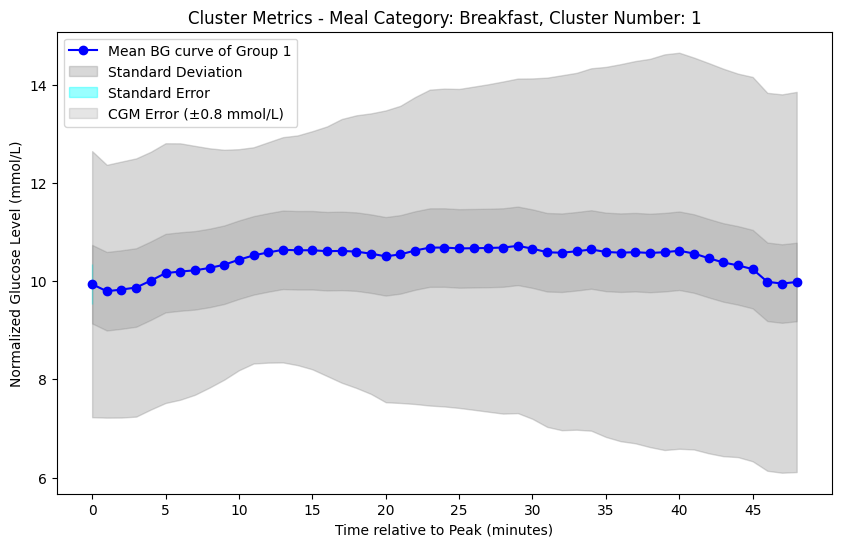

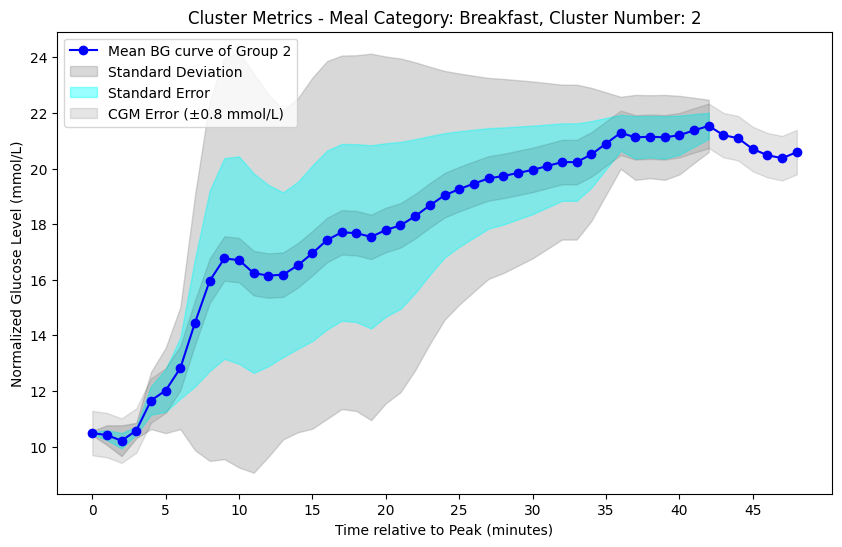

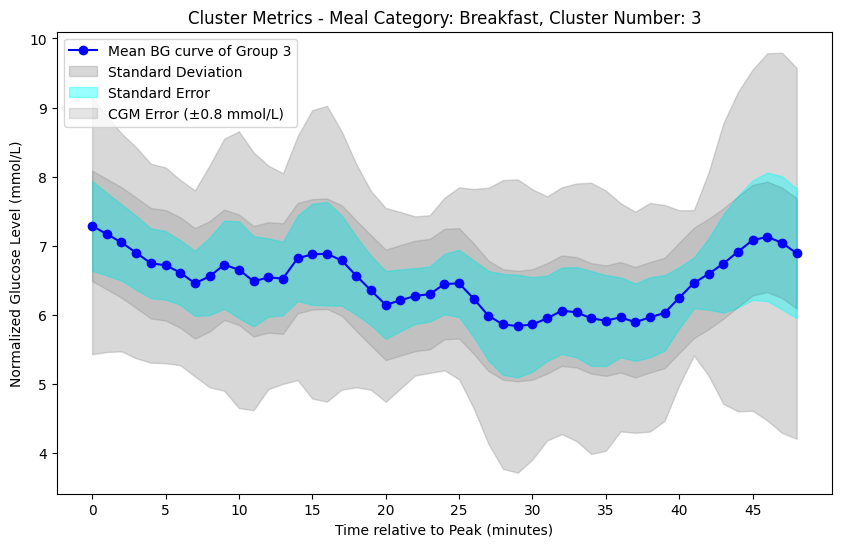

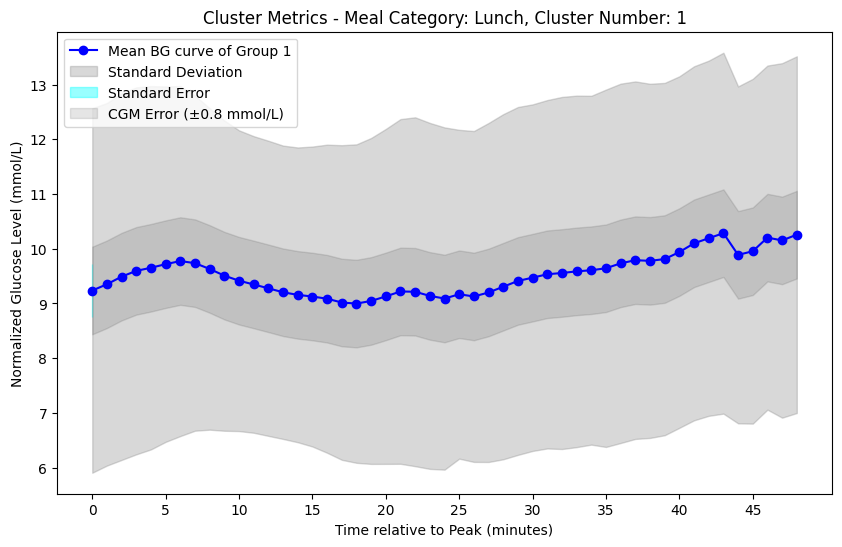

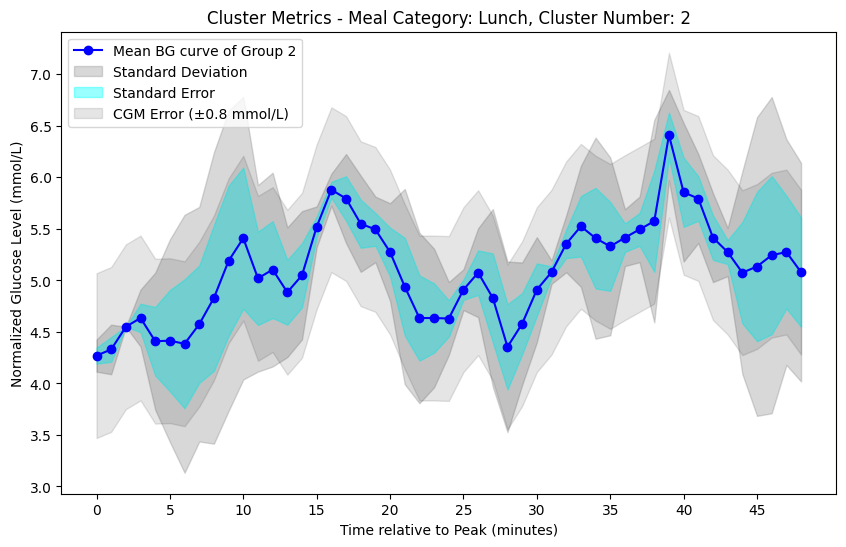

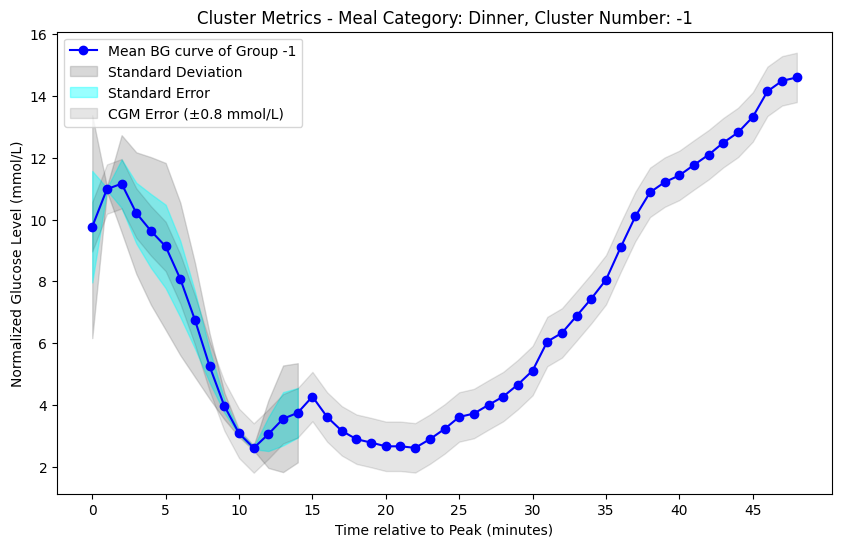

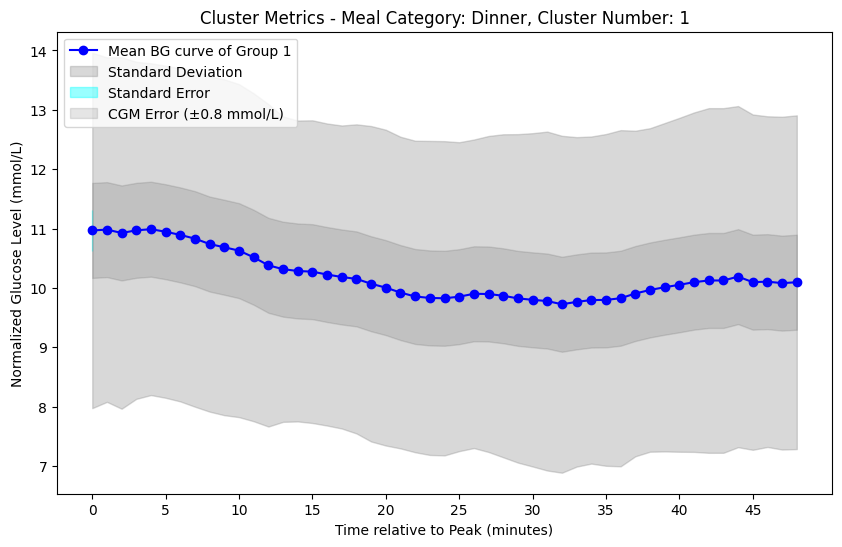

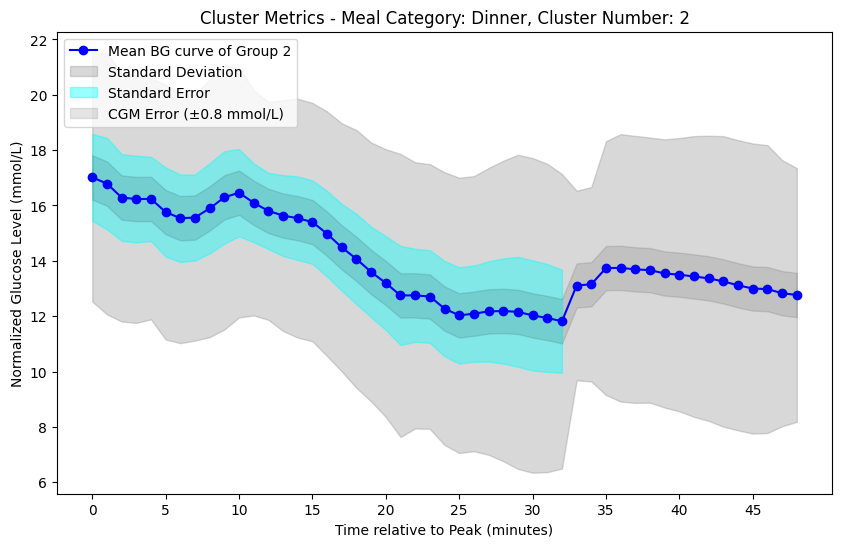

In [21]:
# Function to plot glucose levels for each group in each meal category
def plot_glucose_curve_from_glucose_levels(GlucoseEvents_exploded_clean):
    # Group by MealCategory and GroupNumber
    grouped = GlucoseEvents_exploded_clean.groupby(['MealCategory', 'GroupNumber'])

    for (meal_category, group_number), group_df in grouped:
        # Explode GlucoseLevels into individual time points
        glucose_levels = group_df['GlucoseLevels'].apply(pd.Series).transpose()
        
        # Calculate mean, std deviation, and std error across rows for each time point
        mean_glucose = glucose_levels.mean(axis=1)
        std_dev = glucose_levels.std(axis=1)
        std_err = glucose_levels.apply(calculate_standard_error, axis=1)

        # Generate x-axis values (assume these represent time relative to peak or another metric)
        x_values = np.arange(len(mean_glucose))

        # Create a new figure for each group
        plt.figure(figsize=(10, 6))

        # Plot mean glucose levels
        plt.plot(x_values, mean_glucose, color='b', marker='o', label=f'Mean BG curve of Group {group_number}')

        # Plot standard deviation as a shaded area
        plt.fill_between(x_values, mean_glucose - std_dev, mean_glucose + std_dev, 
                         color='gray', alpha=0.3, label='Standard Deviation')

        # Plot standard error as a shaded area
        plt.fill_between(x_values, mean_glucose - std_err, mean_glucose + std_err, 
                         color='cyan', alpha=0.4, label='Standard Error')

        # Optional: Add a CGM error range of ±0.8 mmol/L around the mean
        plt.fill_between(x_values, mean_glucose - 0.8, mean_glucose + 0.8, 
                         color='black', alpha=0.1, label='CGM Error (±0.8 mmol/L)')

        # Customize titles, labels, and legend
        plt.title(f"Cluster Metrics - Meal Category: {meal_category}, Cluster Number: {group_number}")
        plt.xlabel("Time relative to Peak (minutes)")
        plt.ylabel("Normalized Glucose Level (mmol/L)")
        plt.legend(loc='upper left', frameon=True)

        # Remove grid lines
        plt.grid(False)

        # Customize x-axis for better readability (assuming time points are consistent)
        plt.xticks(np.arange(0, len(mean_glucose), 5))  # Adjust tick values if time values are known

        # Display the plot for this group
        plt.show()

# Example usage
# Replace `GlucoseEvents_exploded_clean` with the actual DataFrame containing your data
plot_glucose_curve_from_glucose_levels(GlucoseEvents_exploded_clean)


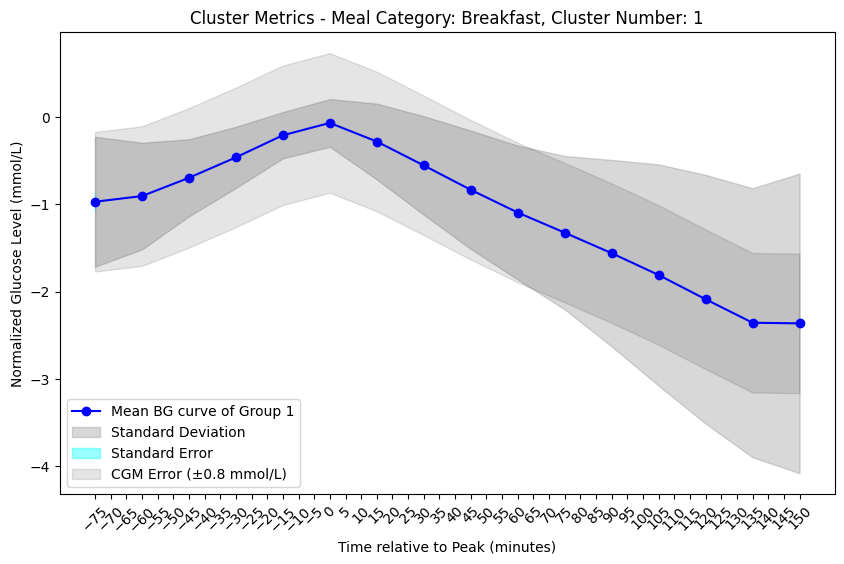

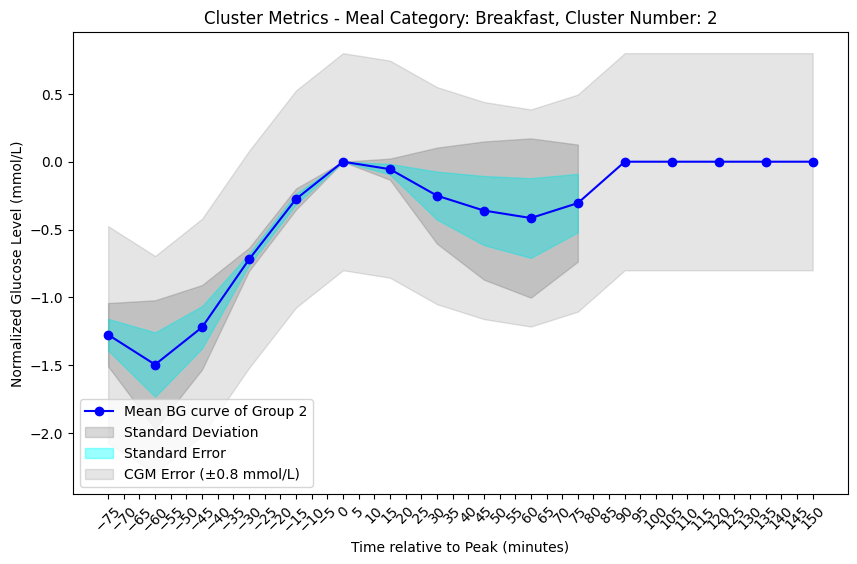

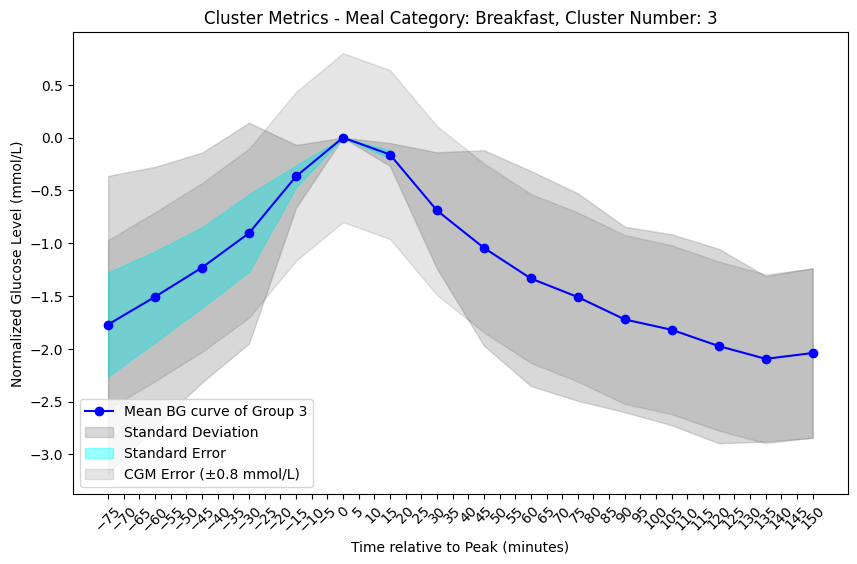

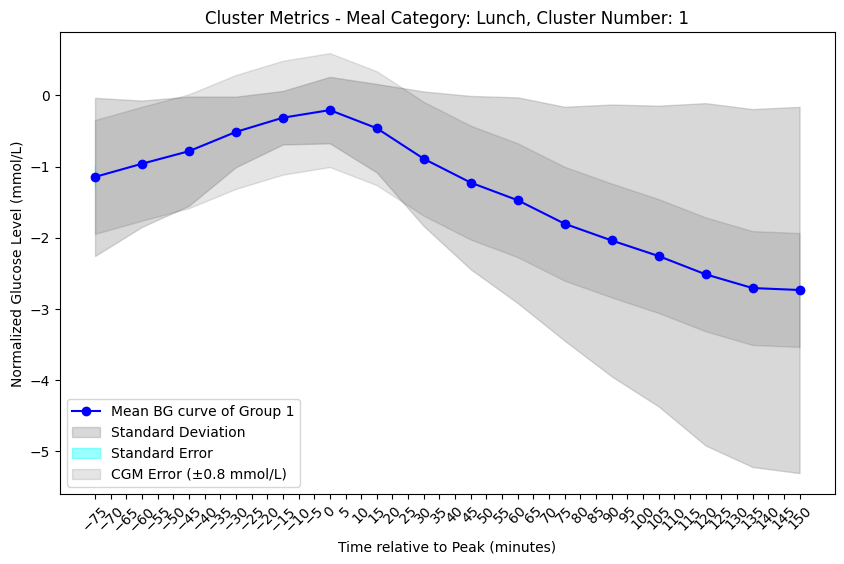

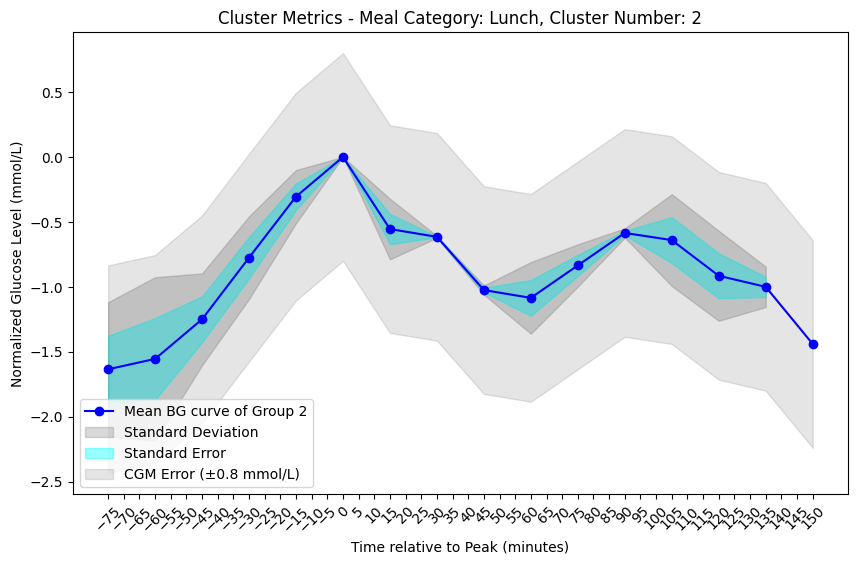

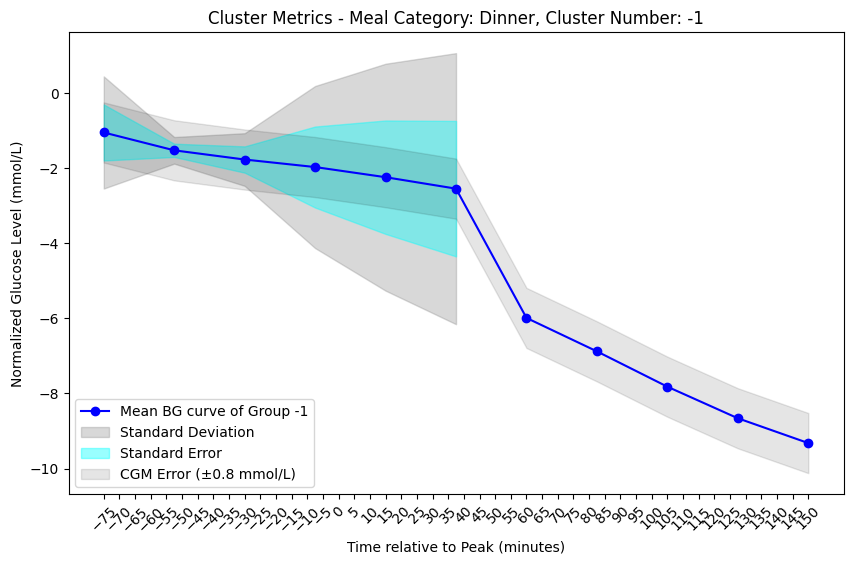

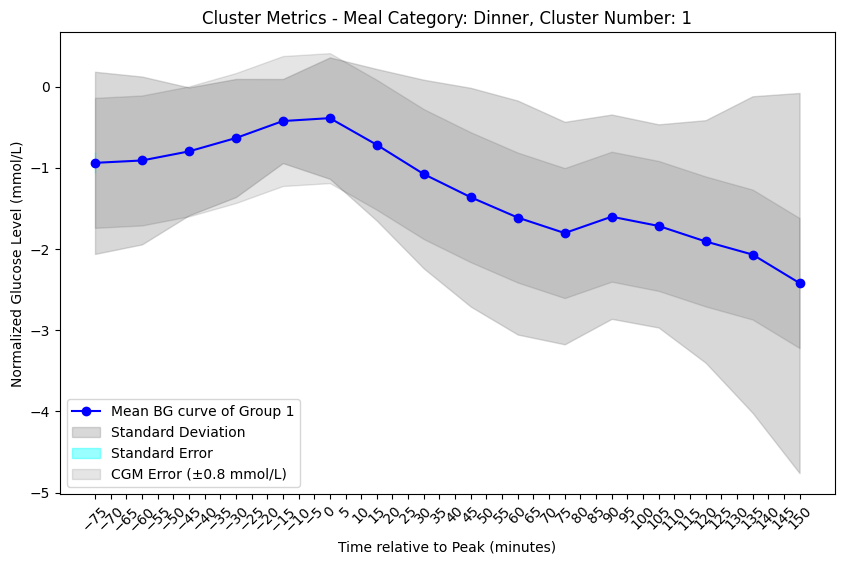

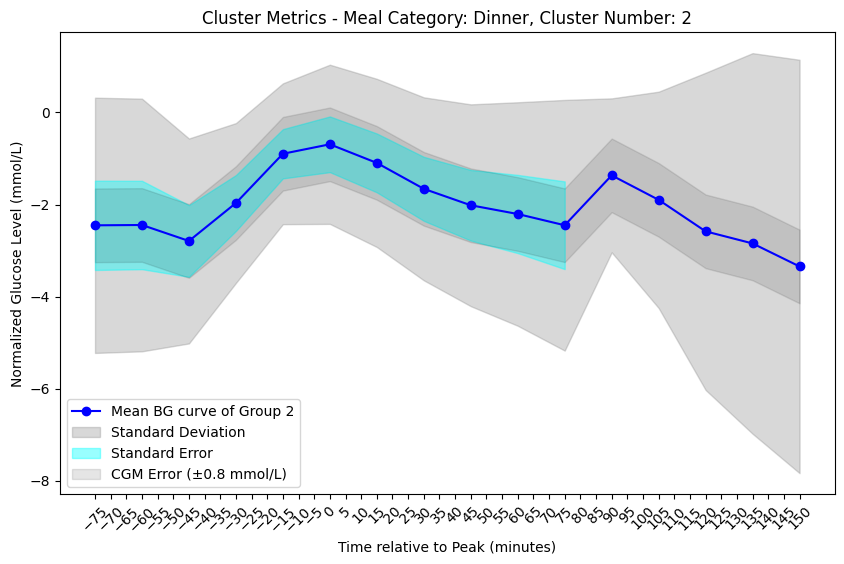

In [23]:
def plot_glucose_curve_with_time_axis(GlucoseEvents_exploded_clean):
    # Group by MealCategory and GroupNumber
    grouped = GlucoseEvents_exploded_clean.groupby(['MealCategory', 'GroupNumber'])

    for (meal_category, group_number), group_df in grouped:
        # Explode GlucoseLevels into individual time points
        glucose_levels = group_df['NormalizedGlucose'].apply(pd.Series).transpose()

        # Calculate mean, std deviation, and std error across rows for each time point
        mean_glucose = glucose_levels.mean(axis=1)
        std_dev = glucose_levels.std(axis=1)
        std_err = glucose_levels.apply(calculate_standard_error, axis=1)

        # Define x-axis values dynamically based on the number of time points
        num_time_points = len(mean_glucose)
        x_values = np.linspace(-75, 150, num_time_points)

        # Create a new figure for each group
        plt.figure(figsize=(10, 6))

        # Plot mean glucose levels
        plt.plot(x_values, mean_glucose, color='b', marker='o', label=f'Mean BG curve of Group {group_number}')

        # Plot standard deviation as a shaded area
        plt.fill_between(x_values, mean_glucose - std_dev, mean_glucose + std_dev, 
                         color='gray', alpha=0.3, label='Standard Deviation')

        # Plot standard error as a shaded area
        plt.fill_between(x_values, mean_glucose - std_err, mean_glucose + std_err, 
                         color='cyan', alpha=0.4, label='Standard Error')

        # Optional: Add a CGM error range of ±0.8 mmol/L around the mean
        plt.fill_between(x_values, mean_glucose - 0.8, mean_glucose + 0.8, 
                         color='black', alpha=0.1, label='CGM Error (±0.8 mmol/L)')

        # Customize titles, labels, and legend
        plt.title(f"Cluster Metrics - Meal Category: {meal_category}, Cluster Number: {group_number}")
        plt.xlabel("Time relative to Peak (minutes)")
        plt.ylabel("Normalized Glucose Level (mmol/L)")
        plt.legend(loc='lower left', frameon=True)

        # Remove grid lines
        plt.grid(False)

        # Set custom x-ticks to match the time intervals
        plt.xticks(np.arange(-75, 155, 5))  # Major ticks every 15 minutes
        plt.xticks(rotation=45)  # Rotate the x-axis labels by 45 degrees

        # Display the plot for this group
        plt.show()

# Example usage
# Replace `GlucoseEvents_exploded_clean` with the actual DataFrame containing your data
plot_glucose_curve_with_time_axis(GlucoseEvents_exploded_clean)
